# Price Predictor Supervised Model

In [24]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from datetime import timedelta
from sqlalchemy import create_engine
import psycopg2
from config import db_password
import numpy as np

## Load in data

In [25]:
# database address
host_name = 'database-1.cvhixt1fojqo.us-east-1.rds.amazonaws.com'

In [26]:
# create the database engine
db_string = f"postgresql://postgres:{db_password}@{host_name}:5432/Crypto_Data"

In [27]:
engine = create_engine(db_string)

In [28]:
crypto_df = pd.read_sql("SELECT * FROM crypto_orig", con=engine)

In [29]:
crypto_df.shape

(5012, 9)

In [30]:
crypto_df.dtypes

type_crypto       object
date_orig         object
daystarttoend      int64
open_            float64
high_            float64
low_             float64
close_           float64
volume_          float64
marketcap_       float64
dtype: object

In [31]:
crypto_df.sample(10)

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_
4925,xrp,2022-01-30,1582,0.618043,0.623104,0.600123,0.604233,8.992425e+08,2.835581e+10
4791,xrp,2021-09-18,1448,1.066335,1.092706,1.059246,1.076488,3.008910e+09,4.984077e+10
1031,ada,2020-07-29,1032,0.148757,0.149498,0.138895,0.139539,9.169335e+08,4.519174e+09
4861,xrp,2021-11-27,1518,0.937300,0.964418,0.937300,0.941909,3.550437e+09,4.398572e+10
836,ada,2020-01-16,837,0.042400,0.043062,0.040178,0.041387,1.266249e+08,1.061381e+09
596,ada,2019-05-21,597,0.085271,0.086444,0.082762,0.084713,2.004563e+08,2.197395e+09
2999,eth,2021-05-25,1332,2641.715104,2743.881519,2407.753852,2691.377005,7.704335e+10,3.000000e+11
4711,xrp,2021-06-30,1368,0.702017,0.713211,0.652779,0.702987,5.428967e+09,3.139538e+10
1230,ada,2021-02-13,1231,0.914822,0.937932,0.822951,0.894094,5.357839e+09,2.818953e+10
2841,eth,2020-12-18,1174,643.444514,662.890065,633.563559,654.529322,3.221118e+10,7.362672e+10


## Transform Datatypes

In [32]:
crypto_df['date_orig'] = pd.to_datetime(crypto_df["date_orig"])
crypto_df.dtypes

type_crypto              object
date_orig        datetime64[ns]
daystarttoend             int64
open_                   float64
high_                   float64
low_                    float64
close_                  float64
volume_                 float64
marketcap_              float64
dtype: object

## Split Data

In [33]:
crypto_list = crypto_df['type_crypto'].unique()
crypto_list

array(['ada', 'eth', 'xrp'], dtype=object)

## ML Model Functions

In [11]:
def pricepredict(df, dt):
    
    # number of future days to predict
    dt_days = dt
    
    # initialize dt column for how far we want to predict
    df['date_pred'] = df['date_orig'] + timedelta(days=dt_days)
    
    # create a copy dataframe to pull target close price
    df_copy = df.copy()
    
    # merge dataframes to get target variable
    df_clean = df.merge(df_copy, how='left', left_on='date_pred', right_on='date_orig', suffixes=(None, '_pred'))

    # drop empty rows
    df_pre_final = df_clean.dropna()
    
    # FOR POSTGRES "crypto_clean" table
    clean_df = df_pre_final[['type_crypto','date_orig','daystarttoend','open_','high_','low_','close_','volume_','marketcap_','date_pred','close__pred']]
    
    # only include relevant features (X) and target variables (y)
    df_final = df_pre_final[['open_','high_','low_','close_','volume_','marketcap_','close__pred']]
    
    # features
    X = df_final.drop('close__pred', axis=1)
    X = X.values.reshape(-1,6)
    
    # target
    y = df_final['close__pred']
    
    # initialize class for linear reg algorithms
    model = LinearRegression()
    
    # fit or train the data
    model.fit(X,y)
    
    # predict outcomes before current date
    y_pred = model.predict(X)
    
    # test data
    df_test = df_clean.loc[pd.isna(df_clean["type_crypto_pred"]),:]
    
    # test features
    X_test = df_test[['open_','high_','low_','close_','volume_','marketcap_']]
    X_test = X_test.values.reshape(-1,6)
    
    # test predictions
    y_pred_future = model.predict(X_test)
    
    # creating output dataframe
    close_pred_series = pd.Series(y_pred).append(pd.Series(y_pred_future))
    close_pred_df = pd.DataFrame(close_pred_series, columns=['close_'])
    close_pred_df.reset_index(inplace=True)
    predict_df = pd.DataFrame(df_clean['type_crypto'])
    predict_df['date_orig'] = df_clean['date_orig']
    predict_df['close_orig'] = df_clean['close_']
    predict_df['date_pred'] = df_clean['date_pred']
    predict_df['close_pred'] = close_pred_df['close_']
    
    # reconfiguring output dataframe
    predict_df_copy = predict_df.copy()
    predict_clean_df = predict_df.merge(predict_df_copy, how='left', left_on='date_pred', right_on='date_orig', suffixes=(None, '_copy'))
    predict_clean_df = predict_clean_df[['type_crypto','date_pred','close_orig_copy','close_pred']]
    predict_clean_df = predict_clean_df.rename(columns={'date_pred':'date','close_orig_copy':'close_orig'})
    
    return clean_df, predict_clean_df

## Model Output

In [12]:
#initial output tables
clean_df_60_day = pd.DataFrame()
predict_df_60_day = pd.DataFrame()
clean_df_30_day = pd.DataFrame()
predict_df_30_day = pd.DataFrame()

In [13]:
# for loop to separate models
for crypto in crypto_list:
    
    # run the ML models
    df = crypto_df.loc[crypto_df['type_crypto'] == crypto,:]
    clean_60_day, predict_60_day = pricepredict(df, 60)
    clean_30_day, predict_30_day = pricepredict(df, 30)
    
    # create the output dataframes
    clean_df_60_day = clean_df_60_day.append(clean_60_day, ignore_index=True)
    predict_df_60_day = predict_df_60_day.append(predict_60_day, ignore_index=True)
    clean_df_30_day = clean_df_30_day.append(clean_30_day, ignore_index=True)
    predict_df_30_day = predict_df_30_day.append(predict_30_day, ignore_index=True)

/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/briancha/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_index

In [35]:
predict_30_day.head(10)

,type_crypto,date,close_orig,close_pred
0,xrp,2017-11-01,0.193735,0.332926
1,xrp,2017-11-02,0.208594,0.335074
2,xrp,2017-11-03,0.207942,0.339015
3,xrp,2017-11-04,0.203550,0.356494
4,xrp,2017-11-05,0.202377,0.341343
5,xrp,2017-11-06,0.206487,0.349558
6,xrp,2017-11-07,0.211300,0.382236
7,xrp,2017-11-08,0.216963,0.362925
8,xrp,2017-11-09,0.217152,0.371946
9,xrp,2017-11-10,0.206114,0.361375


In [36]:
clean_df_60_day.sample(10)

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_,date_pred,close__pred
1934,eth,2018-08-24,327,278.488261,284.428124,274.170431,283.794123,1.454832e+09,2.827547e+10,2018-10-23,201.275689
4767,xrp,2021-12-23,1544,0.954392,1.013843,0.941467,0.993368,4.280461e+09,4.548571e+10,2022-02-21,0.701537
1492,ada,2021-11-02,1493,1.949752,1.995119,1.938403,1.971497,2.318328e+09,6.185485e+10,2022-01-01,1.369334
1673,eth,2017-12-06,66,463.431501,464.670470,420.398632,431.452252,1.225235e+09,4.301803e+10,2018-02-04,835.657302
101,ada,2018-01-11,102,0.786566,0.789126,0.549516,0.688185,2.362297e+08,1.865583e+10,2018-03-12,0.218402
939,ada,2020-04-28,940,0.046503,0.047721,0.046077,0.046896,1.486591e+08,1.219615e+09,2020-06-27,0.077416
3014,eth,2021-08-08,1407,3167.280000,3186.742437,2961.769635,3016.880691,5.155091e+10,3.620000e+11,2021-10-07,3594.659129
308,ada,2018-08-06,309,0.131354,0.135907,0.127164,0.130735,5.013467e+07,3.403887e+09,2018-10-05,0.083287
609,ada,2019-06-03,610,0.097071,0.098748,0.090399,0.090490,2.788835e+08,2.456051e+09,2019-08-02,0.057445
872,ada,2020-02-21,873,0.058211,0.059941,0.057641,0.058733,1.464599e+08,1.526182e+09,2020-04-21,0.034566


In [37]:
predict_df_60_day.sample(10)

,type_crypto,date,close_orig,close_pred
316,ada,2018-10-13,0.073770,0.162229
2021,eth,2018-11-19,150.557750,302.249198
1554,ada,2022-03-04,0.842670,1.180324
2894,eth,2021-04-10,2142.175399,2302.666805
750,ada,2019-12-21,0.033061,0.166012
3687,xrp,2018-11-09,0.499418,0.411432
3574,xrp,2018-07-19,0.474918,0.561950
1019,ada,2020-09-15,0.093153,0.278353
2785,eth,2020-12-22,635.279993,611.389073
893,ada,2020-05-12,0.050358,0.172563


In [38]:
clean_df_30_day.sample(10)

,type_crypto,date_orig,daystarttoend,open_,high_,low_,close_,volume_,marketcap_,date_pred,close__pred
4635,xrp,2021-06-14,1352,0.883778,0.925056,0.865412,0.891833,4.303717e+09,4.070050e+10,2021-07-14,0.618632
3380,xrp,2018-01-06,97,3.020492,3.426593,2.961477,3.140551,4.590550e+09,1.200000e+11,2018-02-05,0.688127
3299,xrp,2017-10-17,16,0.255734,0.262538,0.223182,0.232413,6.437781e+08,9.620641e+09,2017-11-16,0.226273
1045,ada,2020-08-12,1046,0.136934,0.137466,0.125850,0.136575,6.347391e+08,4.210538e+09,2020-09-11,0.096399
3157,eth,2021-11-29,1520,4298.531080,4460.029100,4297.359300,4452.264132,4.195250e+10,5.170000e+11,2021-12-29,3639.101876
389,ada,2018-10-26,390,0.073475,0.073500,0.072084,0.073234,1.172632e+07,1.890617e+09,2018-11-25,0.037768
3571,xrp,2018-07-16,288,0.445573,0.471896,0.442743,0.471896,2.263271e+08,1.784669e+10,2018-08-15,0.280148
4054,xrp,2019-11-11,771,0.279392,0.280892,0.271117,0.274412,1.678373e+09,1.192908e+10,2019-12-11,0.220821
4243,xrp,2020-05-18,960,0.201097,0.206571,0.201097,0.205094,1.141231e+09,8.845032e+09,2020-06-17,0.193223
106,ada,2018-01-16,107,0.780047,0.788655,0.460528,0.621661,1.686280e+08,1.698956e+10,2018-02-15,0.390615


## Model Accuracy

In [39]:
# Accuracy by Root Ream Squared Error
rmse = np.mean((predict_df_30_day['close_pred'] - predict_df_30_day['close_orig'])**2)**.5
print(f'The root mean squared error is {rmse}')

The root mean squared error is 226.25270841018036


In [40]:
#Accuracy by Mean Absolute Percentage Error
mape = np.mean(np.abs((predict_df_30_day['close_pred'] - predict_df_30_day['close_orig'])/np.abs(predict_df_30_day['close_orig'])))
print(f'The mean absolute percentage error is {mape}')

The mean absolute percentage error is 0.5148019177117298


## High Level Visualization

In [41]:
ada_predict_df_30_day = predict_df_30_day.loc[predict_df_30_day['type_crypto'] == 'ada',:]
ada_predict_df_60_day = predict_df_60_day.loc[predict_df_60_day['type_crypto'] == 'ada',:]

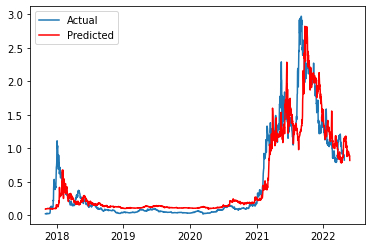

In [42]:
# TABLEAU VISUALIZATION
plt.plot(ada_predict_df_30_day.date, ada_predict_df_30_day.close_orig)
plt.plot(ada_predict_df_30_day.date, ada_predict_df_30_day.close_pred, color='red')
plt.legend(["Actual", "Predicted"])
plt.show()

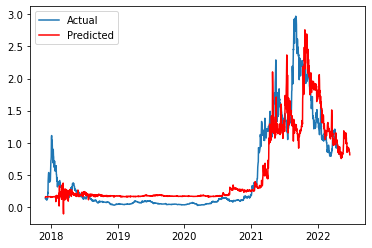

In [43]:
# TABLEAU VISUALIZATION
plt.plot(ada_predict_df_60_day.date, ada_predict_df_60_day.close_orig)
plt.plot(ada_predict_df_60_day.date, ada_predict_df_60_day.close_pred, color='red')
plt.legend(["Actual", "Predicted"])
plt.show()

## Removing Timestamp

In [145]:
predict_df_60_day['date'] = predict_df_60_day['date'].dt.date

In [147]:
predict_df_30_day['date'] = predict_df_30_day['date'].dt.date

In [149]:
clean_df_60_day['date_orig'] = clean_df_60_day['date_orig'].dt.date

In [150]:
clean_df_60_day['date_pred'] = clean_df_60_day['date_pred'].dt.date

In [151]:
clean_df_30_day['date_orig'] = clean_df_30_day['date_orig'].dt.date

In [152]:
clean_df_30_day['date_pred'] = clean_df_30_day['date_pred'].dt.date

## Send to Postgres

In [159]:
predict_df_60_day.to_sql(name='predict_df_60_day', index=False, con=engine)

In [160]:
predict_df_30_day.to_sql(name='predict_df_30_day', index=False, con=engine)

In [161]:
clean_df_60_day.to_sql(name='clean_df_60_day', index=False, con=engine)

In [ ]:
clean_df_30_day.to_sql(name='clean_df_30_day', index=False, con=engine)